In [1]:
#import PyStan
import stan
import nest_asyncio # https://pystan.readthedocs.io/en/latest/faq.html
nest_asyncio.apply()

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import arviz as az # For visualization and loo
import seaborn as sns 
from patsy import dmatrices

In [3]:
#read data
data = pd.read_csv('data_h.csv', encoding='ISO-8859-1')
data.head(5)

/var/folders/5s/b6g_tw4n3t3fbn7c24jtsd2m0000gn/T/ipykernel_76559/2467537502.py:2: DtypeWarning: Columns (3,8,9,12,13,15,21,23,24,26,32,37,49,51,52,54,57) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv('data_h.csv', encoding='ISO-8859-1')


,Unnamed: 0,X,Country,ID,Test_date,obs_n.x,Test_name.x,DOB_est,Birth_year,Grade,...,Overall_score,dis_syntactic,dis_phonology,dis_genetic,Genetic_score_j,Eng_duration.trans.x,Eng_duration.trans.y,Eng_duration.trans,DOB_est_date,age
0,1,1,Aruba,BOU-1281-2,2016/08/01,1,NaN,01-Jul,2010,K,...,155.0,0.4,0.3433,0.9,57.0,0.000000,0.000000,0.000000,2010/07/01,6.090411
1,2,2,Aruba,BOU-1281-2,2017/09/01,2,MODEL,01-Jul,2010,1,...,264.0,0.4,0.3433,0.9,57.0,2.639057,2.639057,2.639057,2010/07/01,7.175342
2,3,3,Aruba,BOU-1281-2,2018/05/01,3,MODEL,01-Jul,2010,1,...,289.0,0.4,0.3433,0.9,57.0,3.091042,3.091042,3.091042,2010/07/01,7.838356
3,4,4,Aruba,BOU-1281-2,2018/09/01,4,MODEL,01-Jul,2010,2,...,306.0,0.4,0.3433,0.9,57.0,3.258097,3.258097,3.258097,2010/07/01,8.175342
4,5,5,Aruba,BOU-1281-2,2019/02/01,5,MODEL,01-Jul,2010,2,...,278.0,0.4,0.3433,0.9,57.0,3.433987,3.433987,3.433987,2010/07/01,8.594521


In [17]:
#select variables and exclude missing values and unreasonable values
data_sub = data[['unique_ID', 'obs_n_new', 'Overall_score', 'dis_genetic', 'Eng_duration', 'age']].dropna()
data_sub = data_sub[data_sub['Overall_score'] >100]
stan_data = {'y': data_sub.Overall_score.to_list(), 
             'AGE': data_sub.age.to_list(), 
             'DURATION': data_sub.Eng_duration.to_list(),
             'DISTANCE': data_sub.dis_genetic.to_list(),
             'N': len(data_sub)}
data_sub

,unique_ID,obs_n_new,Overall_score,dis_genetic,Eng_duration,age
0,International School of Aruba.csv_BOU-1281-2,1,155.0,0.9,0.0,6.090411
1,International School of Aruba.csv_BOU-1281-2,2,264.0,0.9,13.0,7.175342
2,International School of Aruba.csv_BOU-1281-2,3,289.0,0.9,21.0,7.838356
3,International School of Aruba.csv_BOU-1281-2,4,306.0,0.9,25.0,8.175342
4,International School of Aruba.csv_BOU-1281-2,5,278.0,0.9,30.0,8.594521
...,...,...,...,...,...,...
6232,Kyiv Christian Academy.csv_82609,2,267.0,0.9,45.0,8.838356
6233,Kyiv Christian Academy.csv_82809,1,155.0,1.0,0.0,6.087671
6234,Kyiv Christian Academy.csv_82809,2,200.0,1.0,45.0,9.838356
6235,Kyiv Christian Academy.csv_90407,1,161.0,1.0,0.0,8.090411


<Axes: >

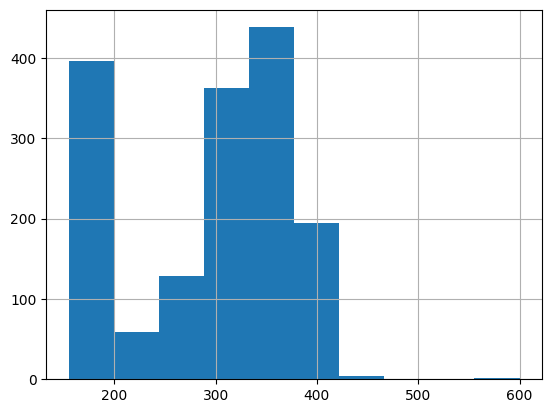

In [145]:
data_sub.Overall_score.hist()

## Fit a mixture model

In [236]:
stan_file = 'mixture_model.stan'
with open(stan_file) as file:
    model_code = file.read()
print(model_code)

data {
  int<lower=1> N;          // number of data points
  array[N] real y;         // observations (overall score)

  vector[N] AGE;           // predictor for component 1, as AGE increases, L1 score increases
  vector[N] DURATION;      // predictor for component 2, as DURATION increases, L2 score increases
  vector[N] DISTANCE;      // predictor for theta which is the proportion of L1 transfer
}

parameters {
  real<lower = 0> sigma;              // variance of score distribution
  real<lower = 0> alpha;              // innate knowledge about langauge
  real<lower = 0> beta;               // learning ability 
  real<lower = 0, upper = 1> exp;     // exposure discount for L2

  real beta_d;                        // slope for theta
}

model {
  //priors
  sigma ~ lognormal(0, 10);
  alpha ~ normal(100, 10);
  beta ~ normal(100, 10);
  exp ~ normal(0.5,0.1);

  beta_d ~ normal(0, 1);

  //likelihood
  for (n in 1:N) {
    vector[2] lps;                                                

In [169]:
compiled_model = stan.build(model_code, data=stan_data, random_seed=1)

Building...

In file included from /Users/weili/Library/Caches/httpstan/4.10.0/models/ub2cbqki/model_ub2cbqki.cpp:2:
In file included from /usr/local/lib/python3.11/site-packages/httpstan/include/stan/model/model_header.hpp:4:
In file included from /usr/local/lib/python3.11/site-packages/httpstan/include/stan/math.hpp:19:
In file included from /usr/local/lib/python3.11/site-packages/httpstan/include/stan/math/rev.hpp:10:
In file included from /usr/local/lib/python3.11/site-packages/httpstan/include/stan/math/rev/fun.hpp:26:
/usr/local/lib/python3.11/site-packages/httpstan/include/stan/math/rev/fun/beta.hpp:70:32: warning: lambda capture 'b' is not used [-Wunused-lambda-capture]
                           [a, b, digamma_ab](auto& vi) mutable {
                             ~~^
In file included from /Users/weili/Library/Caches/httpstan/4.10.0/models/ub2cbqki/model_ub2cbqki.cpp:2:
In file included from /usr/local/lib/python3.11/site-packages/httpstan/include/stan/model/model_header.hpp:4:
In file inclu

ld: warning: direct access in function 'long double boost::math::detail::bessel_j0<long double>(long double)' from file '/usr/local/lib/python3.11/site-packages/httpstan/stan_services.o' to global weak symbol 'long double boost::math::detail::bessel_j0<long double>(long double)::Q2' from file 'build/temp.macosx-11-x86_64-cpython-311/Users/weili/Library/Caches/httpstan/4.10.0/models/ub2cbqki/model_ub2cbqki.o' means the weak symbol cannot be overridden at runtime. This was likely caused by different translation units being compiled with different visibility settings.
ld: warning: direct access in function 'long double boost::math::detail::bessel_j0<long double>(long double)' from file '/usr/local/lib/python3.11/site-packages/httpstan/stan_services.o' to global weak symbol 'long double boost::math::detail::bessel_j0<long double>(long double)::P2' from file 'build/temp.macosx-11-x86_64-cpython-311/Users/weili/Library/Caches/httpstan/4.10.0/models/ub2cbqki/model_ub2cbqki.o' means the weak s

In [175]:
def init_values():
    return {
        "sigma": 10,
        "exp": 0.5,
        "beta": 100,
        "alpha": 100,
        "beta_l1": 0,
        "beta_l2": 0,
        "beta_d": 0,
    }

num_chains = 2
init_values_list = [init_values() for _ in range(num_chains)]

fit = compiled_model.sample(
    num_chains=num_chains,
    num_warmup=500,
    num_samples=1000,
    init=init_values_list,
)

Sampling:   0%
Sampling: 100%, done.
Messages received during sampling:
  Gradient evaluation took 0.026549 seconds
  1000 transitions using 10 leapfrog steps per transition would take 265.49 seconds.
  Adjust your expectations accordingly!
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: normal_lpdf: Location parameter is inf, but must be finite! (in '/var/folders/5s/b6g_tw4n3t3fbn7c24jtsd2m0000gn/T/httpstan__j6elnou/model_ub2cbqki.stan', line 34, column 4 to column 44)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: normal_lpdf: Location parameter is inf, but must be finite! (in '/var/folders

In [247]:
az.summary(fit)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
sigma,49.033,0.992,47.233,50.991,0.015,0.011,4192.0,3517.0,1.0
alpha,203.675,2.073,199.786,207.613,0.031,0.022,4628.0,3506.0,1.0
beta,97.267,8.931,80.155,113.914,0.170,0.120,2788.0,2547.0,1.0
exp,0.414,0.040,0.343,0.488,0.001,0.001,2799.0,2575.0,1.0
beta_d,-2.727,0.196,-3.098,-2.353,0.004,0.003,3052.0,3179.0,1.0
...,...,...,...,...,...,...,...,...,...
y_pred[1578],350.467,46.448,266.622,441.868,0.595,0.421,6096.0,5965.0,1.0
y_pred[1579],203.674,45.519,115.939,288.348,0.613,0.433,5519.0,5583.0,1.0
y_pred[1580],351.794,47.212,266.244,443.668,0.612,0.433,5949.0,5802.0,1.0
y_pred[1581],203.545,46.108,115.068,286.654,0.606,0.429,5788.0,5850.0,1.0


<Axes: title={'center': 'beta_d'}>

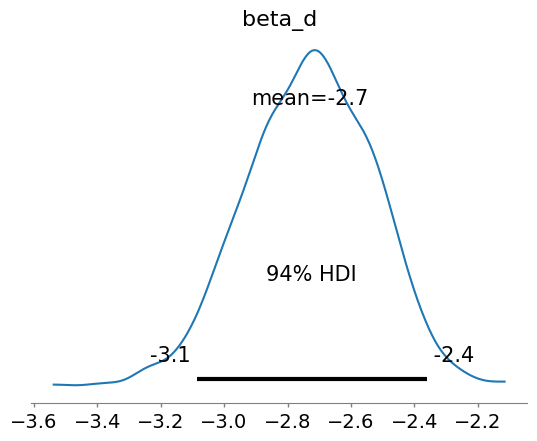

In [163]:
idata = az.from_pystan(posterior=fit, posterior_model=compiled_model)
az.plot_posterior(idata,var_names = ['beta_d'])

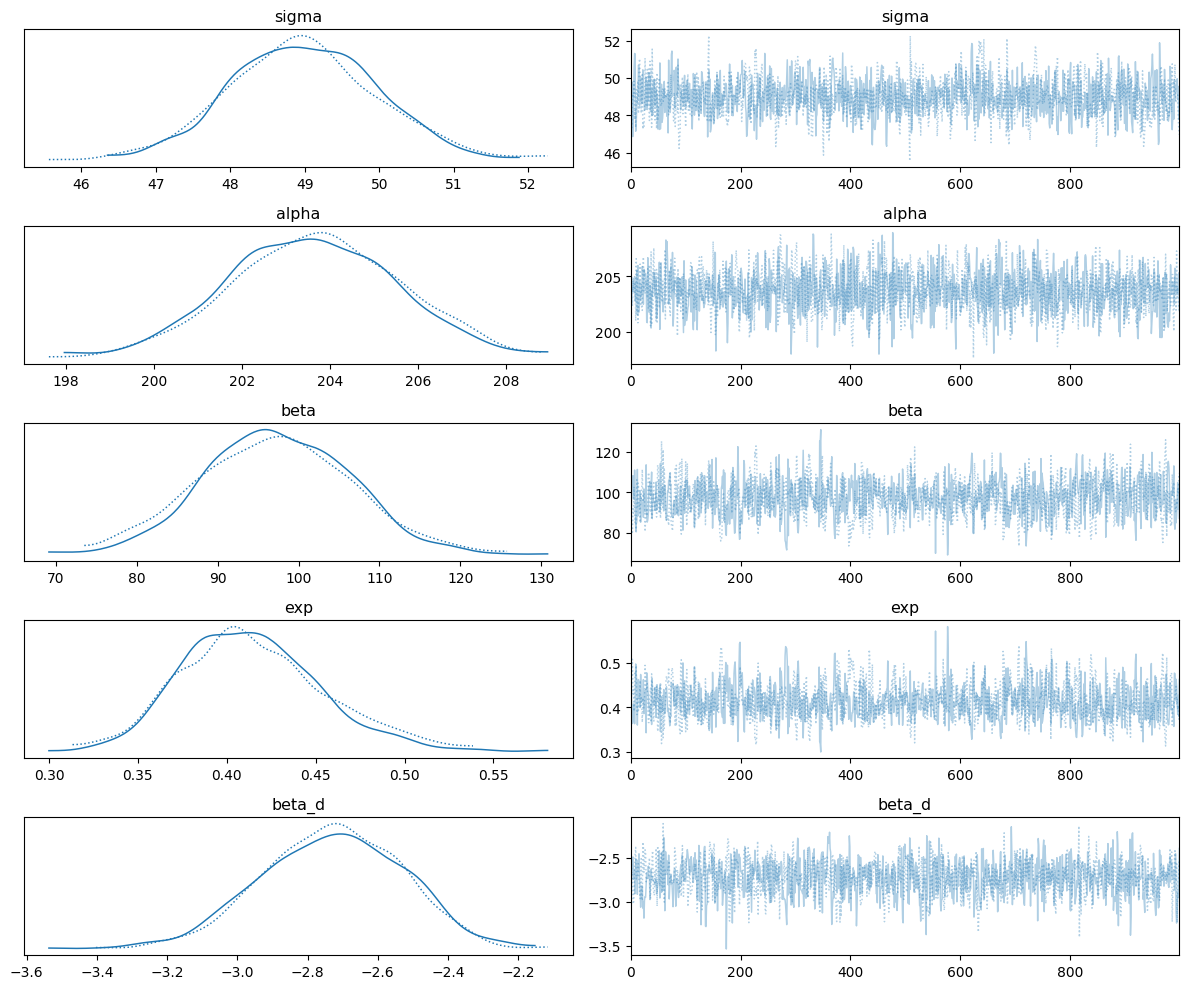

In [167]:
az.plot_trace(idata)
plt.tight_layout()
plt.show()

In [268]:
import cmdstanpy
import numpy as np

# Compile the Stan model
model = cmdstanpy.CmdStanModel(stan_file=stan_file)

fit = model.sample(data=stan_data, chains=2, iter_warmup=500, iter_sampling=1000)

23:29:56 - cmdstanpy - INFO - CmdStan start processing
chain 1 |██████████| 01:14 Sampling completed                       
chain 2 |██████████| 01:14 Sampling completed                       


23:31:11 - cmdstanpy - INFO - CmdStan done processing.
23:31:11 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Location parameter is inf, but must be finite! (in '/var/folders/5s/b6g_tw4n3t3fbn7c24jtsd2m0000gn/T/tmpnc59m7mq/tmp1j93g1iv.stan', line 34, column 4 to column 44)
	Exception: normal_lpdf: Location parameter is inf, but must be finite! (in '/var/folders/5s/b6g_tw4n3t3fbn7c24jtsd2m0000gn/T/tmpnc59m7mq/tmp1j93g1iv.stan', line 34, column 4 to column 44)
	Exception: normal_lpdf: Location parameter is inf, but must be finite! (in '/var/folders/5s/b6g_tw4n3t3fbn7c24jtsd2m0000gn/T/tmpnc59m7mq/tmp1j93g1iv.stan', line 34, column 4 to column 44)
	Exception: normal_lpdf: Location parameter is inf, but must be finite! (in '/var/folders/5s/b6g_tw4n3t3fbn7c24jtsd2m0000gn/T/tmpnc59m7mq/tmp1j93g1iv.stan', line 34, column 4 to column 44)
	Exception: normal_lpdf: Location parameter is inf, but must be finite! (in '/var/folders/5s/b6g_tw4n3t3fbn7c24jtsd2m0000gn

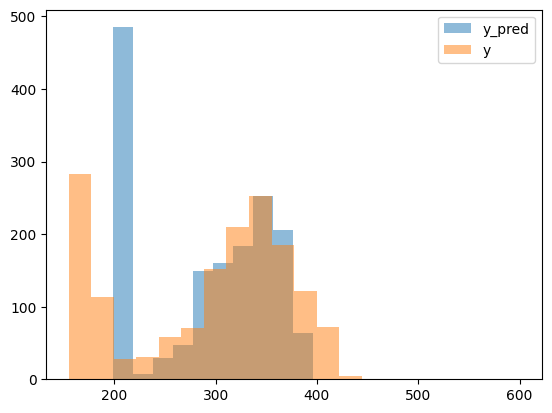

In [275]:
# Get parameter estimates
y_pred = fit.stan_variable('y_pred')
plt.hist(y_pred[1000:].mean(axis=0), bins=10, alpha=0.5, label='y_pred')
plt.hist(stan_data['y'], bins=20, alpha = 0.5, label='y')
plt.legend()
plt.show()